In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil

import wfdb
from wfdb import processing

%matplotlib inline

/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Reading records and annotations

In [2]:
record_id = '16273'
segment_len = 2000
start=0
end=start+segment_len
record_path = '../nsrDb/'+record_id

In [3]:
# Demo 1 - Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
record = wfdb.rdrecord(record_path, sampfrom=start, sampto=end) 

#wfdb.plot_wfdb(record=record, annotation=annotation,
#               title='Record 16265',
#               time_units='seconds', figsize=(10,20))

print(record.__dict__)

{'record_name': '16273', 'n_sig': 2, 'fs': 128, 'counter_freq': None, 'base_counter': None, 'sig_len': 2000, 'base_time': datetime.time(8, 0), 'base_date': None, 'comments': ['28 F'], 'sig_name': ['ECG1', 'ECG2'], 'p_signal': array([[-0.305, -0.165],
       [-0.265, -0.145],
       [-0.245, -0.155],
       ...,
       [-0.165,  0.015],
       [-0.175,  0.025],
       [-0.135,  0.025]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['16273.dat', '16273.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [-61, -33], 'checksum': [50188, 34138], 'block_size': [0, 0]}


In [4]:
raw = record.__dict__['p_signal'][:,0] #Take only 1st channel - ECG1
fs = record.fs
print(fs)
print(raw.shape)
print(raw)

128
(2000,)
[-0.305 -0.265 -0.245 ... -0.165 -0.175 -0.135]


## Write record into .csv file

In [5]:
time = np.linspace(0, segment_len/fs, segment_len)
print(len(time))
time

2000


array([0.00000000e+00, 7.81640820e-03, 1.56328164e-02, ...,
       1.56093672e+01, 1.56171836e+01, 1.56250000e+01])

In [6]:
file = pd.DataFrame()
file['timestamp'] = time
file['ecg_measurement'] = raw
file

timestamp  ecg_measurement
0      0.000000           -0.305
1      0.007816           -0.265
2      0.015633           -0.245
3      0.023449           -0.235
4      0.031266           -0.235
5      0.039082           -0.155
6      0.046898           -0.395
7      0.054715           -0.805
8      0.062531           -0.585
9      0.070348            1.145
10     0.078164            2.715
11     0.085980            3.235
12     0.093797            1.885
13     0.101613            0.275
14     0.109430           -0.255
15     0.117246           -0.415
16     0.125063           -0.445
17     0.132879           -0.395
18     0.140695           -0.395
19     0.148512           -0.415
20     0.156328           -0.385
21     0.164145           -0.335
22     0.171961           -0.355
23     0.179777           -0.395
24     0.187594           -0.355
25     0.195410           -0.305
26     0.203227           -0.325
27     0.211043           -0.385
28     0.218859           -0.395
29     0.226676           -0.325
...         ...              ...
1970  15.398324            3.235
1971  15.406141            2.605
1972  15.413957            0.905
1973  15.421773            0.065
1974  15.429590           -0.275
1975  15.437406           -0.355
1976  15.445223           -0.355
1977  15.453039           -0.315
1978  15.460855           -0.305
1979  15.468672           -0.315
1980  15.476488           -0.315
1981  15.484305           -0.295
1982  15.492121           -0.285
1983  15.499937           -0.295
1984  15.507754           -0.275
1985  15.515570           -0.255
1986  15.523387           -0.265
1987  15.531203           -0.265
1988  15.539020           -0.255
1989  15.546836           -0.245
1990  15.554652           -0.255
1991  15.562469           -0.245
1992  15.570285           -0.215
1993  15.578102           -0.205
1994  15.585918           -0.195
1995  15.593734           -0.215
1996  15.601551           -0.195
1997  15.609367           -0.165
1998  15.617184           -0.175
1999  15.625000           -0.135

[2000 rows x 2 columns]

In [7]:
file_name = '/tmp/nsrDb_' + record_id + '_' + str(start) + '.csv'
file.to_csv(file_name, index=False)

## Peak detection with `qrs_detector` from c-labpl

In [8]:
import sys
sys.path.insert(0, '/home/singuyen/project_biosignal/c-labpl.qrs_detector.master')

from QRSDetectorOffline import QRSDetectorOffline

qrs peaks indices
[  15   93  171  248  325  403  482  564  647  730  811  891  972 1051
 1130 1210 1288 1362 1437 1513 1589 1665 1739 1814 1893 1974]
noise peaks indices
[]


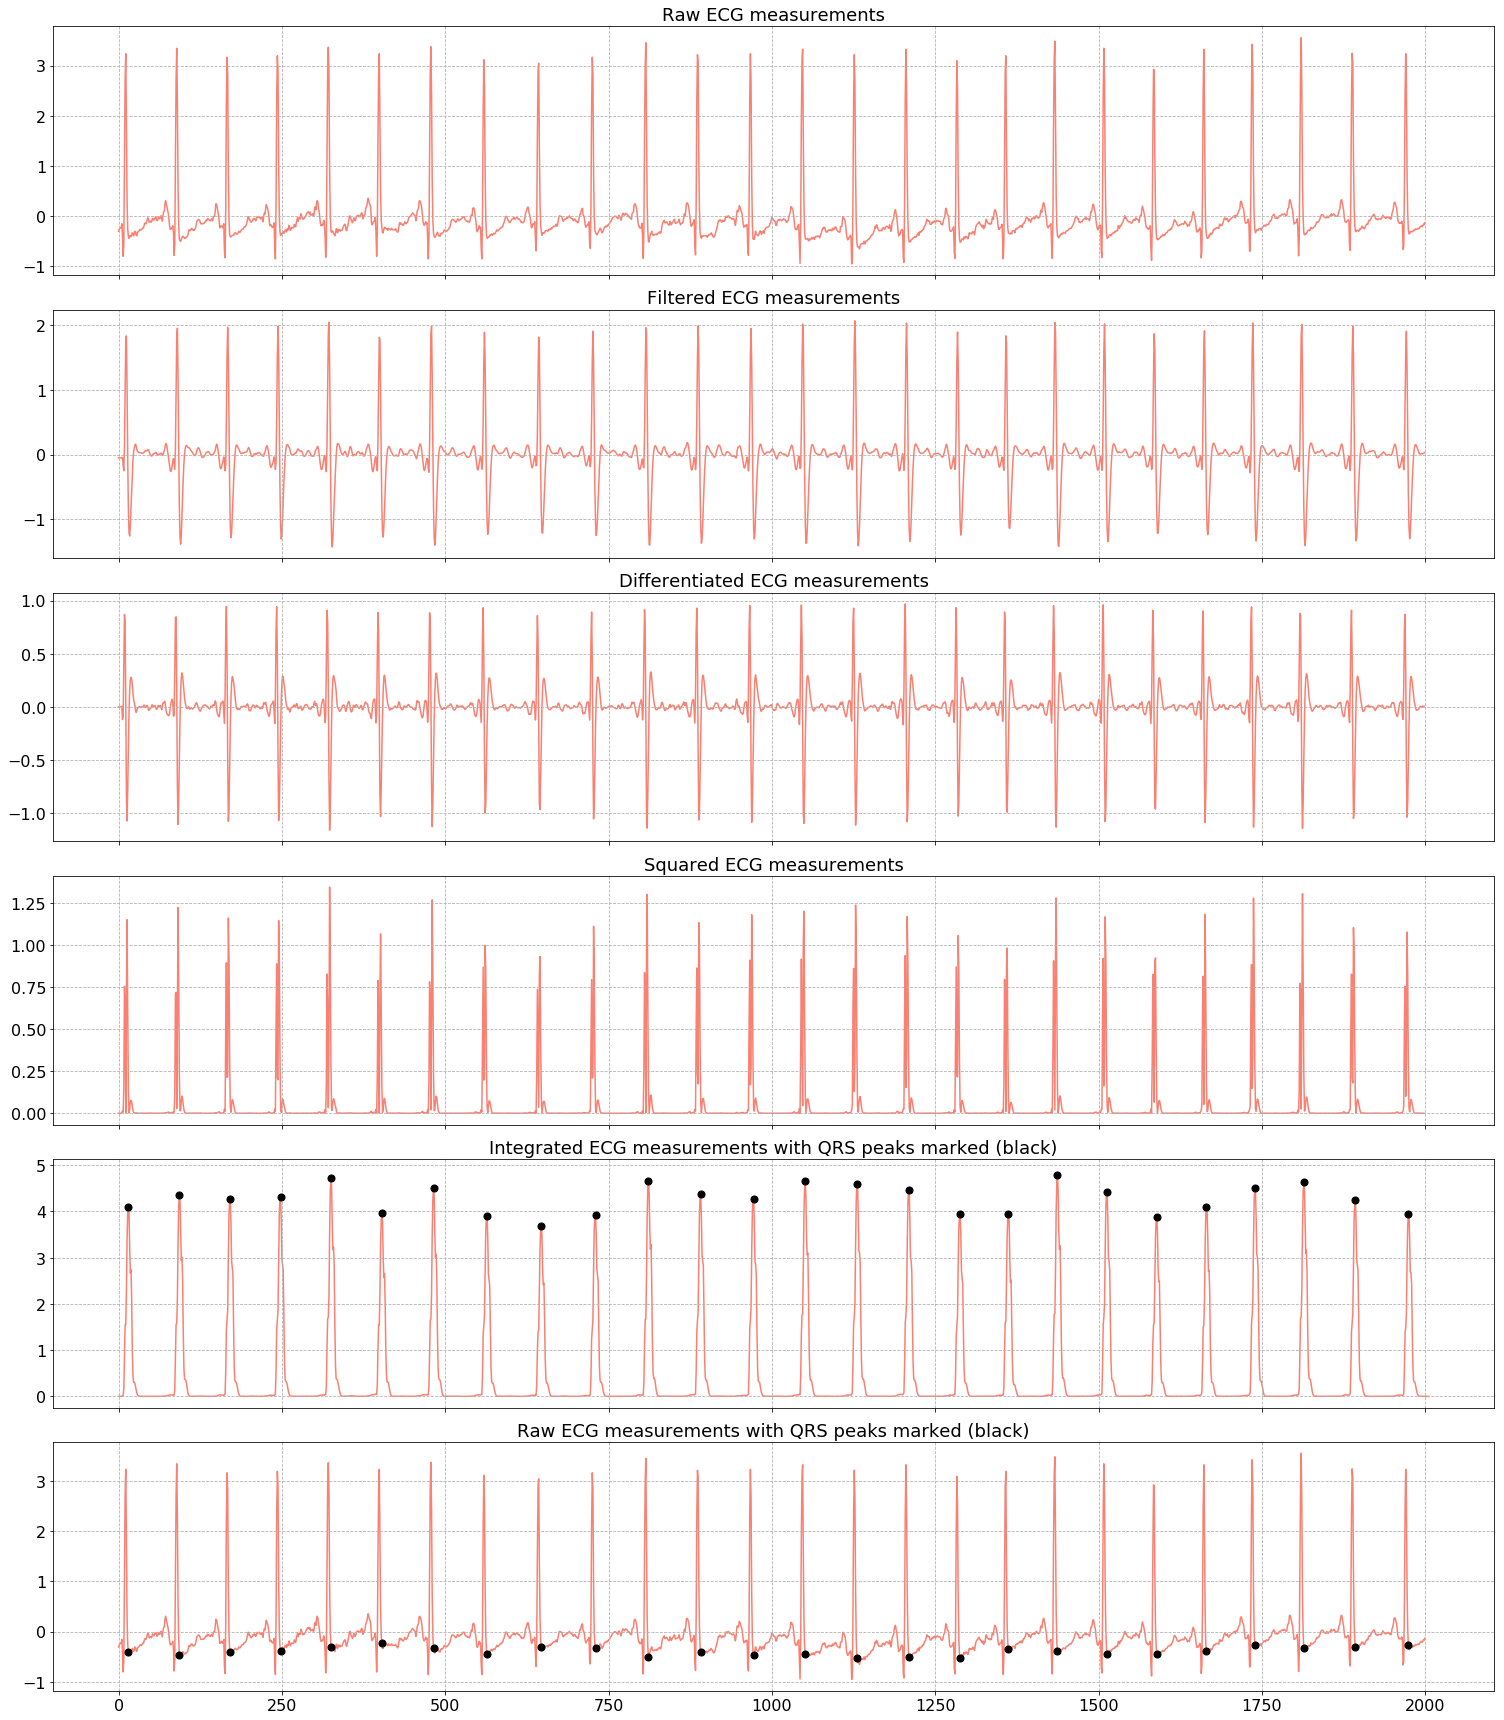

In [9]:
qrs_detector = QRSDetectorOffline(ecg_data_path=file_name, fs=fs, verbose=True,
                                  findpeaks_limit=0.01, findpeaks_spacing_factor=0.2,
                                  log_data=False, plot_data=True, show_plot=True)

## Validation

In [10]:
detected_inds = qrs_detector.qrs_peaks_indices
detected_inds

array([  15,   93,  171,  248,  325,  403,  482,  564,  647,  730,  811,
        891,  972, 1051, 1130, 1210, 1288, 1362, 1437, 1513, 1589, 1665,
       1739, 1814, 1893, 1974])

In [11]:
detected_inds + start

array([  15,   93,  171,  248,  325,  403,  482,  564,  647,  730,  811,
        891,  972, 1051, 1130, 1210, 1288, 1362, 1437, 1513, 1589, 1665,
       1739, 1814, 1893, 1974])

In [12]:
annotation = wfdb.rdann(record_path, 'atr', sampfrom=start, sampto=end)
annotation.sample

array([   9,   87,  164,  241,  319,  397,  476,  557,  641,  723,  804,
        884,  965, 1044, 1124, 1203, 1281, 1356, 1431, 1506, 1583, 1659,
       1733, 1808, 1886, 1968])

In [13]:
# Compare detected qrs complexes to reference annotation.
# Note, first sample in atr is not a qrs.
comparitor = processing.compare_annotations(ref_sample = annotation.sample[1:],
                                            test_sample = detected_inds+start,
                                            window_width = int(0.1 * fs),
                                            signal = raw)

# Print the results
comparitor.print_summary()

25 reference annotations, 26 test annotations

True Positives (matched samples): 25
False Positives (unmatched test samples: 1
False Negatives (unmatched reference samples): 0

Specificity: 1.0000 (25/25)
Positive Predictivity: 0.9615 (25/26)
False Positive Rate: 0.0385 (1/26)
